## Top 1 Top5 and Top 10 accuracies for 25 classes 

Model 3 - This model is trained on 25 random classes. We have calculated the top1, top5 and top 10 accuracy for this model. We have drawn a confusion matrix with true positive and false positive rate, we have also calculated the F1 score, Recall and precision. We have also dispalyed few prediction using interactive classification for our model.

##### Random seed for 5-Fold

In [1]:
SEED = 42
from random import seed as py_seed
py_seed(SEED)
from numpy.random import seed as np_seed
np_seed(SEED)
from tensorflow import random as tf_random
tf_random.set_seed(SEED)

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import KFold, train_test_split
import pickle
import matplotlib.pyplot as plt
import functools
from keras import backend as K
import keras
import tensorflow as tf
import os
import numpy as np 

Read 101 categories and randomly select 25 categories. Read data only from those folders. 

In [4]:
# Data comes from here. This should contain a bunch of folders of classes, each containing examples
#DATA_PATH = Path('food-101-original-source/images')
DATA_PATH = Path('images')
SAVE_PATH = '25_runs/'

# Get class (folder) names
classes = sorted([entry.name for entry in DATA_PATH.iterdir() if entry.is_dir()])

SPLIT = 25
random.shuffle(classes) # shuffle the classes 
classes = classes[:SPLIT]
classes = sorted(classes)
# Load list of filenames and classes, and convert to numpy array to allow array slicing
# For k-fold validation
dataset = np.array([
    (f"{clazz}/{entry.name}", clazz)
    for clazz in classes
    for entry in (DATA_PATH / clazz).iterdir()
])

In [5]:
# Randomly selected classes 
print(classes)

['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'chocolate_cake', 'deviled_eggs', 'dumplings', 'filet_mignon', 'french_onion_soup', 'french_toast', 'frozen_yogurt', 'greek_salad', 'grilled_salmon', 'huevos_rancheros', 'hummus', 'nachos', 'paella', 'panna_cotta', 'peking_duck', 'pork_chop', 'prime_rib', 'ramen', 'spring_rolls', 'steak', 'takoyaki']


In [6]:
# create data generators

# Rescale 0-255 to 0-1
RESCALE=1./255

# This type of data generator is used to train the model
train_datagen = ImageDataGenerator(
    rescale=RESCALE,
    # Factors used to control
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
)

# This type of generator is used to test the model
test_datagen = ImageDataGenerator(
    rescale=RESCALE,
)

### Function for Top 10 accuracy

In [7]:
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

In [8]:
# model function
def create_model(input_shape, num_classes):
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = RMSprop()

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy','top_k_categorical_accuracy',top10_acc] # top1, top5 and top10 accuracies
    )
    
    return model


In [14]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1056)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1056)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                26425     
Total params: 4,296,141
Trainable params: 26,425
Non-trainable params: 4,269,716
_________________________________________________________________


In [9]:
# Image data generator settings
TARGET_SIZE = (224,224)
COLOR_MODE = "rgb"
BATCH_SIZE = 64
CLASS_MODE = "categorical"


# Training settings
NUM_FOLDS = 5
VALIDATION_SPLIT = 0.1
NUM_EPOCHS = 5

# Model settings
kf = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)
results = []
cur_fold = 1

# saving classes used by this model
with open(SAVE_PATH+'classes_25.txt', 'w') as f:
    f.writelines("%s\n" % clss for clss in classes)


for train_index, test_index in kf.split(dataset):
    # Print a message
    print(f"Fold {cur_fold} of {NUM_FOLDS}")
    cur_fold += 1
    
    # Extract train dataset
    d_train = dataset[train_index]
    # Split train dataset to form train and validation dataset
    d_train, d_val = train_test_split(dataset, test_size = VALIDATION_SPLIT)
    
    # These are used to convert the filename,class pairs to dataframes
    FILENAME_COL = "filename"
    CLASS_COL = "class"
    COLUMNS = [FILENAME_COL, CLASS_COL]
    # Convert to dataframes
    d_train = pd.DataFrame(d_train, columns = COLUMNS)
    d_val = pd.DataFrame(d_val, columns = COLUMNS)
    
    # Create training data generators
    # Training image data generator
    train_it = train_datagen.flow_from_dataframe(
        d_train,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = True,
        seed = SEED
    )
    # Validation image data generator
    val_it = test_datagen.flow_from_dataframe(
        d_val,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = False,
    )
    
    # Perform training
    # Build the model
    input_shape = (*TARGET_SIZE,3)
    num_classes = len(classes)
    model = create_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_it,
        validation_data=val_it,
        epochs=NUM_EPOCHS,
        workers=6,
        max_queue_size=100,
        verbose=True
    )
    
    # Extract test dataset and convert to dataframe
    d_test = pd.DataFrame(dataset[test_index], columns = COLUMNS)
    # Create test image data generator
    test_it = test_datagen.flow_from_dataframe(
        d_test,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = False,
    )
    
    
    # Save history to a file 
    with open(SAVE_PATH+"history_25_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(history, file)   
        
    # saving labels to a file (y_test)
    with open(SAVE_PATH+"y_test_25_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(test_it.classes, file)

    # predict model
    y_predict = model.predict(test_it)
    
    # save it to a file (Y_predict)
    with open(SAVE_PATH+"y_predict_25_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(y_predict, file)

    
     # Test
    fold_results = model.evaluate(test_it)
    results.append(fold_results)
    print(f"Results for current fold: {fold_results}")

Fold 1 of 5
Found 22500 validated image filenames belonging to 25 classes.
Found 2500 validated image filenames belonging to 25 classes.
Epoch 1/5
352/352 [==============================] - 731s 2s/step - loss: 2.5829 - accuracy: 0.2624 - top_k_categorical_accuracy: 0.5849 - top10_acc: 0.7715 - val_loss: 2.1747 - val_accuracy: 0.3572 - val_top_k_categorical_accuracy: 0.7620 - val_top10_acc: 0.9032
Epoch 2/5
352/352 [==============================] - 691s 2s/step - loss: 2.0796 - accuracy: 0.3905 - top_k_categorical_accuracy: 0.7424 - top10_acc: 0.8892 - val_loss: 1.9907 - val_accuracy: 0.4104 - val_top_k_categorical_accuracy: 0.8024 - val_top10_acc: 0.9296
Epoch 3/5
352/352 [==============================] - 694s 2s/step - loss: 1.9568 - accuracy: 0.4262 - top_k_categorical_accuracy: 0.7737 - top10_acc: 0.9052 - val_loss: 2.0997 - val_accuracy: 0.4192 - val_top_k_categorical_accuracy: 0.8004 - val_top10_acc: 0.9240
Epoch 4/5
352/352 [==============================] - 693s 2s/step - los

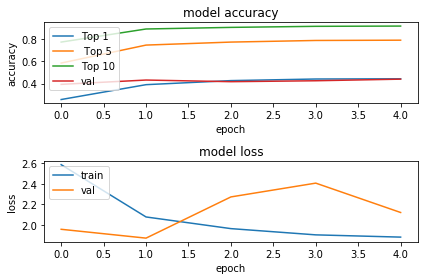

In [10]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['top10_acc'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Top 1', ' Top 5','Top 10' , 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.show()

In [11]:
y_pred = []
for i in y_predict:
    y_pred.append(np.argmax(i, axis=0))

 Confusion Matrix 


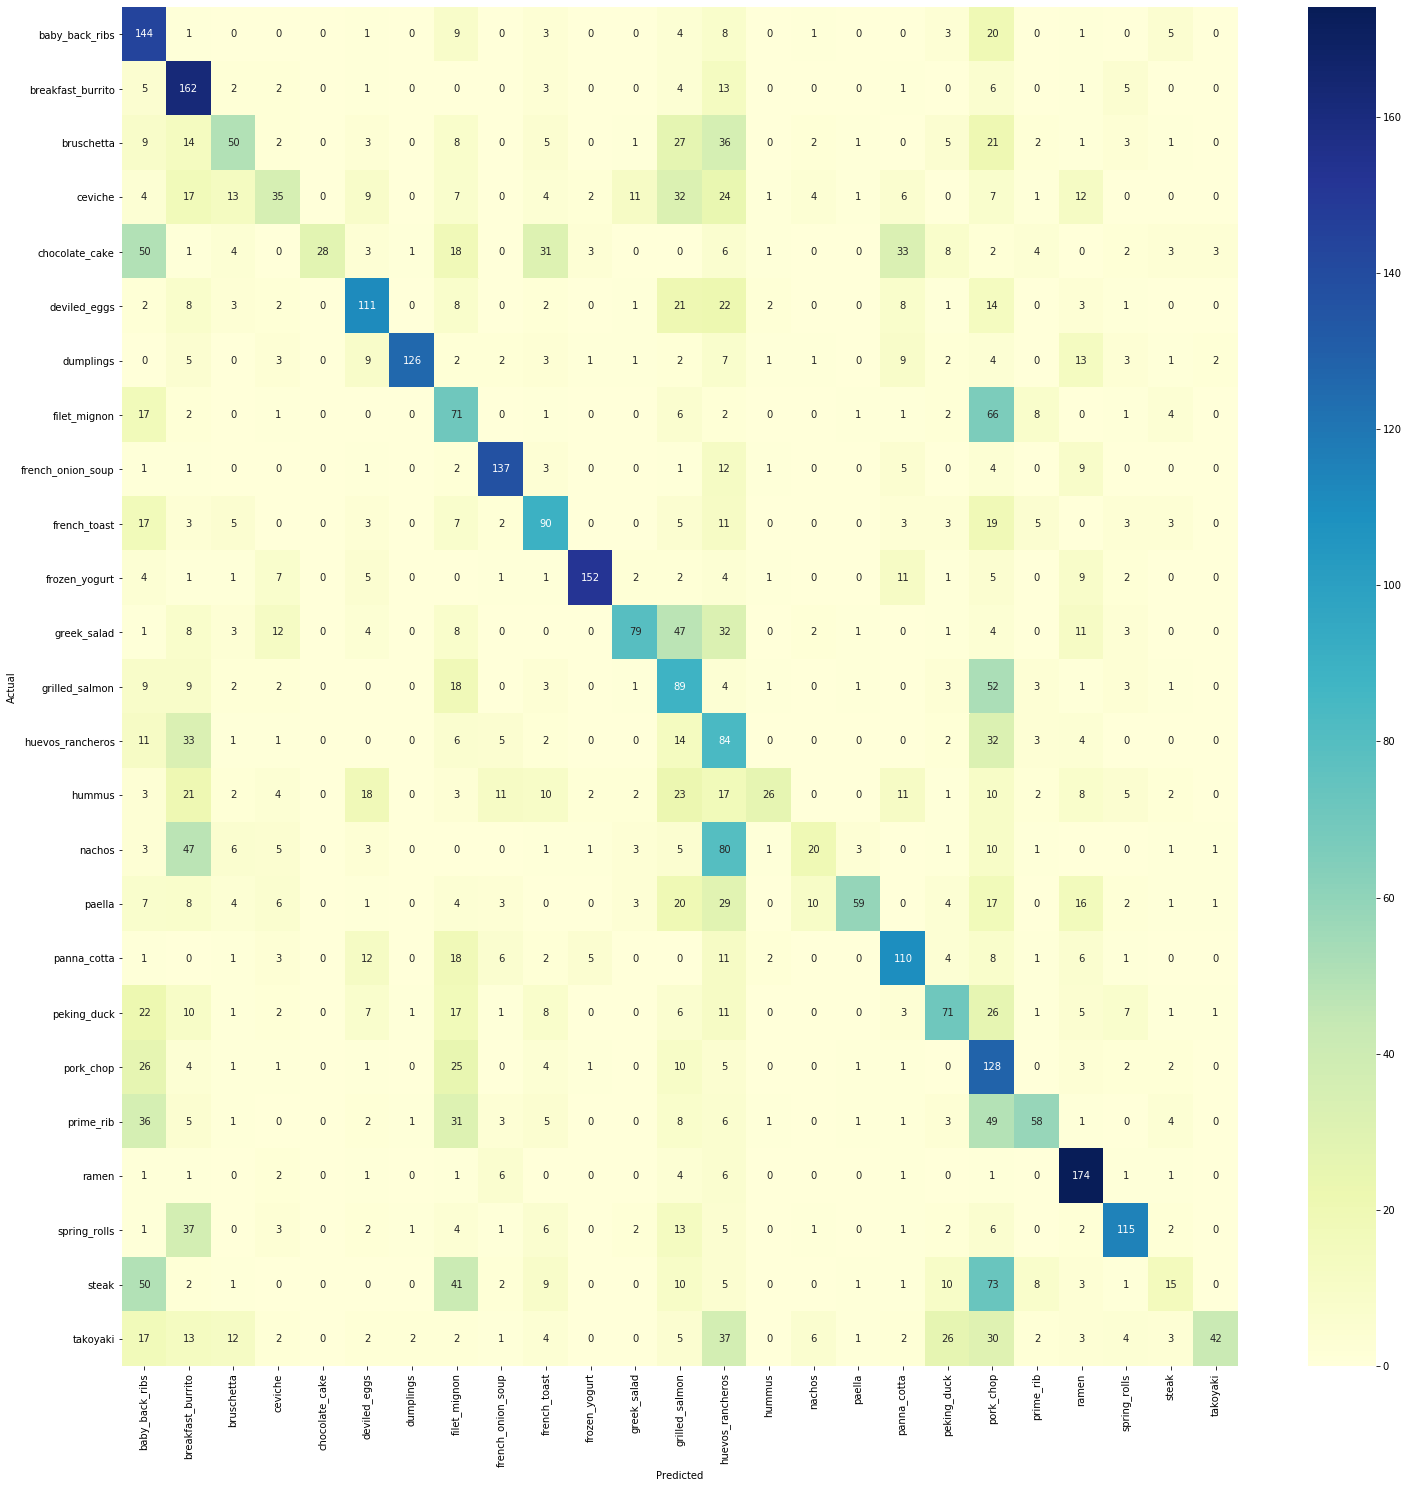

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print(" Confusion Matrix ")
conf_mat = confusion_matrix(test_it.classes, y_pred)
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

results = confusion_matrix(test_it.classes, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(test_it.classes, y_pred))
print ('Report : ')
print (classification_report(test_it.classes, y_pred))

Confusion Matrix :
[[144   1   0   0   0   1   0   9   0   3   0   0   4   8   0   1   0   0
    3  20   0   1   0   5   0]
 [  5 162   2   2   0   1   0   0   0   3   0   0   4  13   0   0   0   1
    0   6   0   1   5   0   0]
 [  9  14  50   2   0   3   0   8   0   5   0   1  27  36   0   2   1   0
    5  21   2   1   3   1   0]
 [  4  17  13  35   0   9   0   7   0   4   2  11  32  24   1   4   1   6
    0   7   1  12   0   0   0]
 [ 50   1   4   0  28   3   1  18   0  31   3   0   0   6   1   0   0  33
    8   2   4   0   2   3   3]
 [  2   8   3   2   0 111   0   8   0   2   0   1  21  22   2   0   0   8
    1  14   0   3   1   0   0]
 [  0   5   0   3   0   9 126   2   2   3   1   1   2   7   1   1   0   9
    2   4   0  13   3   1   2]
 [ 17   2   0   1   0   0   0  71   0   1   0   0   6   2   0   0   1   1
    2  66   8   0   1   4   0]
 [  1   1   0   0   0   1   0   2 137   3   0   0   1  12   1   0   0   5
    0   4   0   9   0   0   0]
 [ 17   3   5   0   0   3   0   7   

## Interactive Classification

In Interactive classification we displaying the Top1, Top 5 and Top 10 prediction made by model 3 (25 classes) 

In [95]:
from PIL import Image
# change the file name if you want to test it with different picture
image_path = []
image_path.append("9.jpg")
image_path.append("38.jpg")
image_path.append("45.jpg")

Resizing the image and converting to array. The prediction for all the image are storeed in result list.

In [96]:
imgPred = []
result = []
for im in range(len(image_path)):
    image = []
    img_resize = (224,224)
    img = Image.open(image_path[im])
    img = img.resize(img_resize)
    img = np.asarray(img)
    image.append(img)
    data_train = np.array(image, dtype=np.float32)/255
    prediction = model.predict([data_train])
    result.append(classes[np.argmax(prediction)])
    imgPred.append( plt.imread(image_path[im]) )

'deviled_eggs'

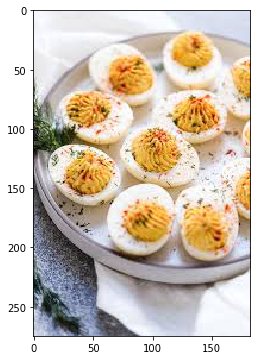

In [97]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[0])
result[0]

'french_onion_soup'

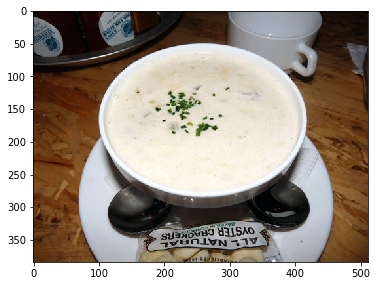

In [98]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[1])
result[1] ## Its Bruchetta

'breakfast_burrito'

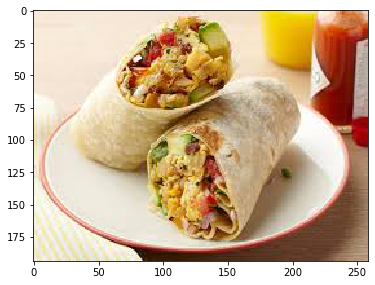

In [99]:
fig = plt.figure()
fig.set_size_inches(6,6)
plt.imshow(imgPred[2])
result[2] ## Its Bruchetta

## Top 5 and Top 10 Prediction

In [100]:
imgPred = []
result = []
top10 = [] 
for im in range(len(image_path)):
    image = []
    img_resize = (224,224)
    img = Image.open(image_path[im])
    img = img.resize(img_resize)
    img = np.asarray(img)
    image.append(img)
    data_train = np.array(image, dtype=np.float32)/255
    prediction = model.predict([data_train])
    result.append(classes[np.argmax(prediction)])
    sorted_prediction = []
    for i in range(len(classes)):
        temp=[]
        temp.append(classes[i])
        temp.append(prediction[0][i])
        sorted_prediction.append(temp)
    sor = sorted(sorted_prediction,key=lambda ls:ls[1], reverse=True)
    res = []
    for j in range(0, 10):
        res.append(sor[j][0]) 
    top10.append(res)

Display top 5 and top 10 for all the images

top 5 and top 10:
deviled_eggs
hummus
bruschetta
grilled_salmon
huevos_rancheros
paella
panna_cotta
baby_back_ribs
ceviche
steak


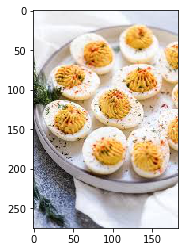

In [101]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[0][i])
img = plt.imread(image_path[0])
plt.imshow(img)

top 5 and top 10:
french_onion_soup
ramen
hummus
panna_cotta
pork_chop
peking_duck
spring_rolls
grilled_salmon
huevos_rancheros
baby_back_ribs


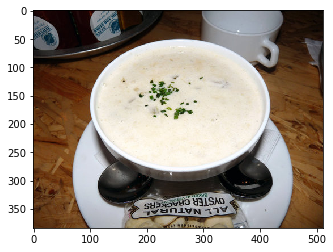

In [102]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[1][i])
img = plt.imread(image_path[1])
plt.imshow(img)

top 5 and top 10:
breakfast_burrito
spring_rolls
grilled_salmon
huevos_rancheros
bruschetta
french_toast
hummus
pork_chop
baby_back_ribs
takoyaki


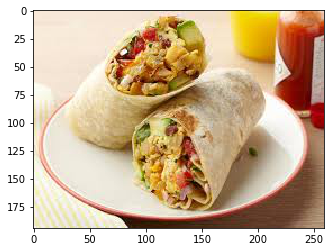

In [103]:
print("top 5 and top 10:")
for i in range(0, 10):
    print(top10[2][i])
img = plt.imread(image_path[2])
plt.imshow(img)